# Diabetic Retinopathy Classification Model

#### Our Objectives
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

---
### Import libraries

In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = 'DiabeticRetinopathy/images/'
LABEL_PATH = 'DiabeticRetinopathy/labels/'

These images are taken using fundus photography and come from working age adults in rural parts of India, part of an effort by the Aravind Eye Hospital. Technicians travel to these rural areas to collect these images and then rely on highly trained doctors to be able to diagnose patients with diabetic retinopathy. There are five possible ratings, corresponding to no diabetic retinopathy (DR), mild DR, moderate DR, severe DR, proliferative DR. All of these labels are made by a clinician. We will be applying a Convolutional Neural Network (CNN) and build a model that can automatically detect different levels of DR.

---
### Reading in the data

Let's load the 2D images and their corresponding labels.

``labels``

In [12]:
labels = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', labels.shape)
print('Unique diagnosis codes:', np.sort(labels.diagnosis.unique()))
labels.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes: 

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


``images``

In [9]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    if img != '.DS_Store':
        img = load_img(
        IMAGE_PATH + img)
        images.append(img)

---
### Inspecting the data

Text(0.5, 1.0, 'Histogram of DR Classifications')

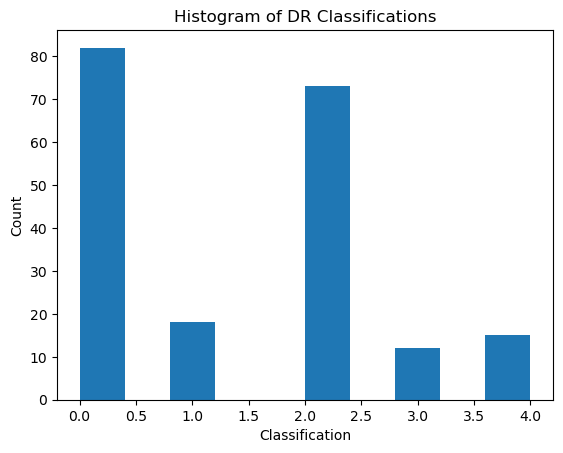

In [16]:
plt.hist(labels['diagnosis'])
plt.xlabel('Classification')
plt.ylabel('Count')
plt.title('Histogram of DR Classifications')

There is definitely some class imbalance here, with an over-representation of no DR and moderate DR. Let's print the first 8 images and see how they look.

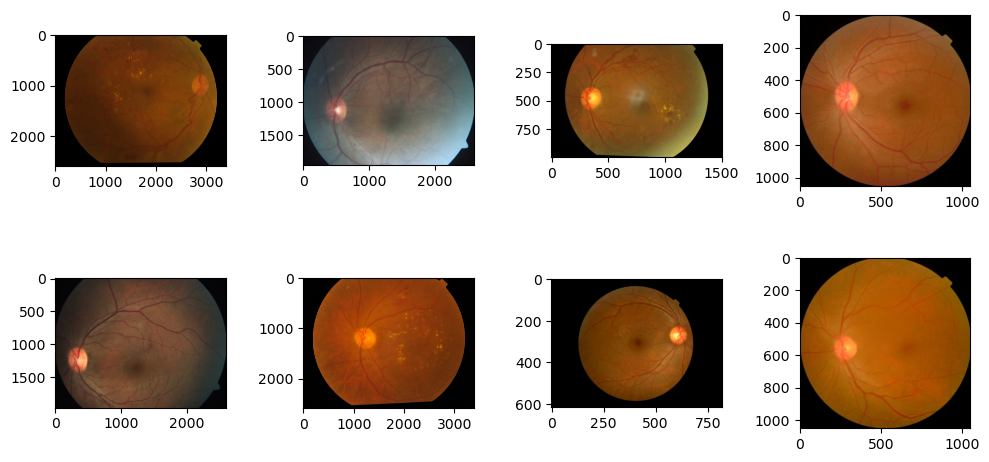

In [21]:
plt.figure(figsize = (10, 5))
for i, image in enumerate(images[:8]):
    plt.subplot(2, 4, i+1)
    plt.imshow(image)

plt.tight_layout()
plt.show()

All of these images are of various lighting, focus, and size, as seen from the first 8 examples above.

---
### Data preprocessing

First, we will correct for class imbalance. This might happen because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for this homework. 

In [22]:
np.random.seed(1234)

no_refer = labels[labels.diagnosis.isin((0,1))]
refer = labels[labels.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

Next, we will use the ``preprocess_data_part1()`` function defined below to generate lists of images and labels (images_mini and y_mini) based on the values in the temp_no_refer and temp_refer lists. Note that the size of the image is set to (224, 224).

In [23]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    temp_no_refer (str): list of labels for the no refer category
    temp_refer (str): list of labels for the refer category
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )
        
        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [24]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


We will do the following for the preprocess_data_part_2:

1. shuffle images and labels before splitting the data

2. use a (0.6,0.2,0.2)train/validation/test set split

3. perform image transformation and augmentation, as follows:
    * Applied on training set only:
         - create additional copies (augmentations) of the training images by flipping left right each image
         - concatenate the augmented images to the original training images. The train set will be double in size after data augmentation, i.e., 192 images and labels.
    * Applied on training, validation, and test sets:
        - normalize all pixel values by dividing by 255.0.

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [27]:
def preprocess_data_part2(images, labels, splits):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)   
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images, labels = images[indices], labels[indices]

    # Calculate split indices
    train_end = int(len(images) * splits[0])
    val_end = train_end + int(len(images) * splits[1])
    
    # create data splits (training, val, and test sets)
    # FILL IN CODE HERE #
    X_train, y_train = images[:train_end], labels[:train_end]
    X_val, y_val = images[train_end:val_end], labels[train_end:val_end]
    X_test, y_test = images[val_end:], labels[val_end:]
    
    # image augmentation (random flip) on training data
    X_train_augm = tf.image.flip_left_right(X_train)

    # concatenate original X_train and augmented X_train_augm data
    X_train = np.concatenate([X_train, X_train_augm], axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor

    # rescale training, val, and test images by dividing each pixel by 255.0 
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [28]:
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Modeling

The objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. We are interested in exploring binary classification of 'no refer' and 'refer'.

We will implement a CNN classifier according to the following guidelines (let's call this model1l this model will serve as our baseline classifier):

1. Implement this model using the TF Keras API.
1. The model receives input images of size 224 x 224 x 3 (that is, the images have three color channels)
2. The input data goes through one convolutional layer that has the following specifications:
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
3. The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). Note: this will reduce the size of the feature maps.
4. The max-pooling layer is followed by a dropout layer with rate = 0.3.
5. The dropout layer is followed by a flattening layer.
6. The last layer of the model is the classification head.
7. Build and compile the model using the Adam optimizer and learning_rate = 0.1.
8. Train the model on (X_train, y_train) data for 20 epochs. 

In [30]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy', 
verbose=1,
patience=4,
mode='max',
restore_best_weights=True)

In [31]:
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model1 = tf.keras.Sequential()

# add convolutional layer to model1
model1.add(tf.keras.layers.Conv2D(filters=12, 
                                  kernel_size=(4, 4), 
                                  padding = 'same', 
                                  activation='relu', 
                                  data_format = 'channels_last',
                                  name = 'conv_1',
                                  strides = (1, 1),
                                  input_shape=(224, 224, 3)))

# add max pooling layer to model1
model1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# add dropout layer to model1
model1.add(tf.keras.layers.Dropout(0.3))


# add a flattening layer to model1
model1.add(tf.keras.layers.Flatten())

# add the classification layer to model1
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))


# build and compile model1
model1.build(input_shape=(None, 224, 224, 3))
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

# print model1 summary
model1.summary()

# train model1 on (X_train, y_train) data
model1.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])


# evaluate the accuracy of model1 on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = model1.evaluate(X_train, y_train)
val_loss, val_acc = model1.evaluate(X_val, y_val)
print(f'Training accuracy: {train_acc}, Validation accuracy: {val_acc}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       150,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,117 (590.30 KB)

 Trainable params: 151,117 (590.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.5074 - loss: 585.7672 - val_accuracy: 0.6562 - val_loss: 0.6803
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.4888 - loss: 0.6951 - val_accuracy: 0.6562 - val_loss: 0.6849
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.5067 - loss: 0.6936 - val_accuracy: 0.3438 - val_loss: 0.6967
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.5112 - loss: 0.6928 - val_accuracy: 0.3438 - val_loss: 0.7099
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.5112 - loss: 0.6935 - val_accuracy: 0.3438 - val_loss: 0.7196
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.5112 - loss: 0.6947 - val_accuracy: 0.3438 - val_loss: 0.7232
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.5112 - loss: 0.6951 - val_accuracy: 0.3438 - val_loss: 0.7217
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 3.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/

Our training accuracy is not great, given that it is 50%, which is what the baseline should be given our split of data. Also, it doesn't generalize well, with a drop off in validation accuracy.

Our model does not seem to generalize well, which we can see from our difference between validation and training accuracy.

Next, we will build a model with a more complex CNN architecture than the baseline CNN classifier above. We do the following:

1. Implement this more complex CNN model (call this model2). 
2. Train the model on (X_train, y_train) data for 20 epochs. We will add early stopping.

In [41]:
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model2 = tf.keras.Sequential()

# add convolutional layer to model2
model2.add(tf.keras.layers.Conv2D(filters=12, 
                                  kernel_size=(4, 4), 
                                  padding = 'same', 
                                  activation='relu', 
                                  data_format = 'channels_last',
                                  name = 'conv_1',
                                  strides = (1, 1),
                                  input_shape=(224, 224, 3)))


model2.add(tf.keras.layers.Conv2D(filters=128,  # Increased the number of filters
                                  kernel_size=(3, 3), 
                                  padding='same', 
                                  activation='relu'))

# add max pooling layer to model2
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# add dropout layer to model2
model2.add(tf.keras.layers.Dropout(0.3))


# add a flattening layer to model2
model2.add(tf.keras.layers.Flatten())

# add the classification layer to model2
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))


# build and compile model2
model2.build(input_shape=(None, 224, 224, 3))
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

# print model2 summary
model2.summary()

# train model2 on (X_train, y_train) data
model2.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])


# evaluate the accuracy of model2 on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = model2.evaluate(X_train, y_train)
val_loss, val_acc = model2.evaluate(X_val, y_val)
print(f'Training accuracy: {train_acc}, Validation accuracy: {val_acc}')

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │        13,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1605632)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │     1,605,633 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,620,173 (6.18 MB)

 Trainable params: 1,620,173 (6.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5050 - loss: 8929.8672 - val_accuracy: 0.6562 - val_loss: 81.4109
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4744 - loss: 291.2860 - val_accuracy: 0.3438 - val_loss: 390.3713
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4838 - loss: 353.1839 - val_accuracy: 0.6562 - val_loss: 318.2469
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5022 - loss: 305.6518 - val_accuracy: 0.3438 - val_loss: 190.0086
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 645ms/step - accuracy: 0.4187 - loss: 137.6585
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step - accuracy: 0.6562 - loss: 81.4109
Training accuracy: 0.46875, Validation accuracy: 0.65625


The validation accuracy is much higher than the training accuracy.

The model generalizes better than the previous model. 

---
### Evaluation

We now use the test data to evaluate the performance (accuracy) of model1 and model2 on unseen data. 

In [42]:
mod1_test_loss, mod1_test_acc = model1.evaluate(X_test, y_test)
print(f'Test accuracy for Model 1: {mod1_test_acc}')
mod2_test_loss, mod2_test_acc = model2.evaluate(X_test, y_test)
print(f'Test accuracy for Model 2: {mod2_test_acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7812 - loss: 1.1014
Test accuracy for Model 1: 0.78125
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step - accuracy: 0.4375 - loss: 133.2184
Test accuracy for Model 2: 0.4375


Model 1 performed way better than Model 2 on the test data.

This result was not expected. Model 2 had more complexities and used more convolutional layers, which made me expect it to perform way better on the data since I would assume it went more in-depth.